# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Описание данных

Данные лежат в файле /datasets/taxi.csv. Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## План работы

#### Шаг 1. Загрузка данных
Загрузим файла с данными taxi_df

#### Шаг 2. Предобработка данных
Изучим данные, при необходимости выполним предобработку. Если нет, то перейдем к следующему шагу.

#### Шаг 3. Исследовательский анализ данных
Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

#### Шаг 4. Подготовка данных
Создадим дополнительные признаки с помщощью функции make_features()

#### Шаг 5. Обучение моделей
Обучим модель линейной регрессии, CatBoostRegressor и LGBM Regressor, оценим их работу с помощью выбранных по ходу проекта метрик и исходя из вида модели.

#### Шаг 6. Оценка моделей
Проверим модели на адекватность, выберем лучшую и проведем предсказания на тестовой выборке

#### Шаг 7. Выводы по проекту
Cоберем промежуточные выводы, а затем дадим общие выводы по всему проекту.

## Импорт библиотек и собственные функции

In [1]:
!pip install phik -q
!pip install shap -q
!pip install --upgrade certifi

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory
    scipy (>=1.0matplotlib>=3.1)
          ~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory
    scipy (>=1.0matplotlib>=3.1)
          ~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory
Defaulting to user installation because normal site-packages is not writeable
    scipy (>=1.0matplotlib>=3.1)
          ~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0

In [2]:
import pandas as pd
import os
from time import time
import requests
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import uniform
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

pd.options.mode.chained_assignment = None
from urllib.request import urlretrieve
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
#функция для вывода первичной информации

def quick_info(df):
    info_buffer = df.info(buf=None)
    
    describe_df = df.describe()
    
    duplicated_count = df.duplicated().sum()
    
    return info_buffer, describe_df, duplicated_count  

#функция для вывода уникальных значений в столбцах датафрейма
 
def print_unique_values(dataframes, columns):
    for i, df in enumerate(dataframes):
        for column in columns:
            print(colored(f"Уникальные значения столбца '{column}' в датафрейме:", 'red', attrs=['bold']))
            print(df[column].sort_values().unique())

In [4]:
#функция для гистограммы и ящика с усами для количественного признака

def histbox(df, exclude_cols=[], bins=50, figsize=(5, 8), title_fontsize=14, axis_fontsize=12):
    
    # Отбор количественных признаков
    
    numeric_features = df.drop(columns=exclude_cols).select_dtypes(include=[np.number]).columns.tolist()
    discrete_features = [col for col in numeric_features if df[col].nunique() < 20]
    continuous_features = [col for col in numeric_features if df[col].nunique() >= 20]
    
    # Количество строк для графиков
    
    num_rows = len(continuous_features) * 2 + len(discrete_features)
    fig, axes = plt.subplots(num_rows, 1, figsize=figsize)
    axes = axes.flatten()

    row = 0
    
    for feature in continuous_features:
        sns.histplot(df[feature], bins=bins, ax=axes[row])
        axes[row].set_title(f'Гистограмма для \n{feature}', fontsize=title_fontsize)
        axes[row].tick_params(axis='both', labelsize=axis_fontsize)
        row += 1
        
        sns.boxplot(x=df[feature], ax=axes[row])
        axes[row].set_title(f'Боксплот для \n{feature}', fontsize=title_fontsize)
        axes[row].tick_params(axis='both', labelsize=axis_fontsize)
        row += 1

    for feature in discrete_features:
        sns.countplot(x=df[feature], ax=axes[row])
        axes[row].set_title(f'Столбчатая диаграмма для \n{feature}', fontsize=title_fontsize)
        axes[row].tick_params(axis='both', labelsize=axis_fontsize)
        row += 1

    plt.tight_layout()
    plt.show()

## Шаг 1. Загрузка и знакомство с данными

In [5]:
pth_1 = 'https://code.s3.yandex.net/datasets/taxi.csv'
pth_2 = 'taxi.csv'  

current_dir = os.getcwd()
local_path = os.path.join(current_dir, pth_2)

if os.path.exists(local_path):
    taxi_df = pd.read_csv(local_path, index_col=[0], parse_dates=[0])
else:
    try:
        urlretrieve(pth_1, local_path)
        taxi_df = pd.read_csv(local_path, index_col=[0], parse_dates=[0])
    except Exception as e:
        print('Что-то пошло не так:', e)

Посмотрим на основную информацию по нашим датафреймам с помощью ранее созданной функции quick_info():

In [6]:
quick_info(taxi_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


(None,
          num_orders
 count  26496.000000
 mean      14.070463
 std        9.211330
 min        0.000000
 25%        8.000000
 50%       13.000000
 75%       19.000000
 max      119.000000,
 26415)

Посмотрим, есть ли пропуски:

In [7]:
print('Количество пропусков:')
taxi_df.isna().mean()

Количество пропусков:


num_orders    0.0
dtype: float64

### Выводы:

- В датафрейме две колонки, названия которых приведены к "змеиному" регистру, и 26496 строк.
- Пропусков и очевидных дубликатов не видим
- Есть данные за полгода: с марта 2018 года по август того же года.
- Скорее всего, данные структурированы по количеству заказов за каждые 10 минут.

## Шаг 2. Предобработка данных

В рамках предыдущего шага мы убедились, что масштабная предобработка данных не потребуется:

- нет пропусков;
- нет дубликатов;
- названия колонок соответствуют змеиному регистру

Проверим, в хронологическом ли порядке расположены даты и время, с помощью атрибута is_monotonic:

In [8]:
taxi_df.sort_index(inplace=True)
print(taxi_df.index.is_monotonic)

True


В нашей задаче нужно спрогнозировать количество заказов такси на следующий час. При этом в текущем датафрейме указано количество заказов такси за каждые 10 минут. Значит, нужно поменять интервал и сгруппировать значения с помощью ресемплинга:

In [9]:
taxi_df = taxi_df.loc['2018-03-01':'2018-08-31']

taxi_df_resampled = taxi_df.resample('1H').sum()
taxi_df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Визуализируем результаты ресемплирования:

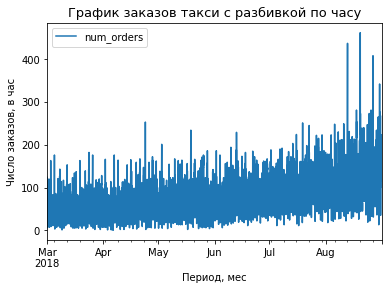

In [10]:
taxi_df_resampled.plot()
plt.title('График заказов такси с разбивкой по часу', fontsize=13)
plt.xlabel('Период, мес')
plt.ylabel('Число заказов, в час')
plt.show()

В таком формате очень сложно что-то понять из графика, разве что видны довольно большие колебания. Попробуем сгладить колебания с помощью скользящего среднего: подходящий размер окна для сглаживания подберем методом перебора.

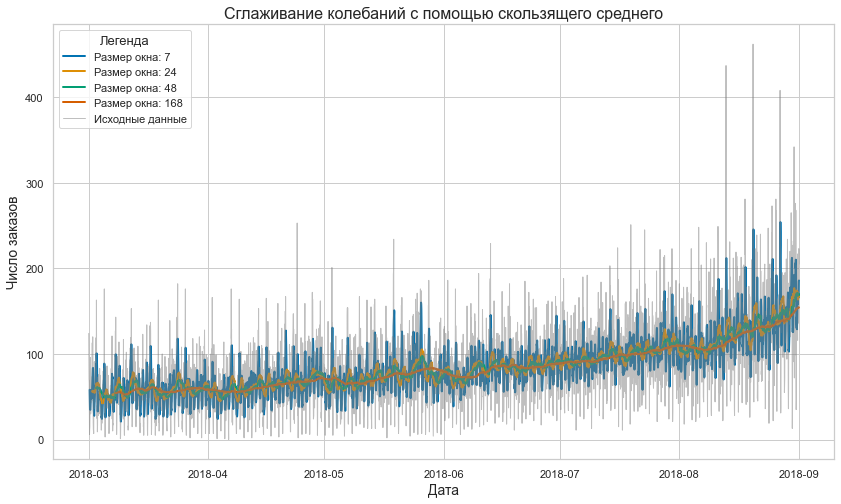

In [11]:
window_sizes = [7, 24, 48, 168]
plt.figure(figsize=(14, 8))
sns.set(style='whitegrid')

palette = sns.color_palette('colorblind', len(window_sizes) + 1)
sns.set_palette(palette)

for i, window in enumerate(window_sizes):
    rolling_mean = taxi_df_resampled.rolling(window=window).mean()
    sns.lineplot(x=taxi_df_resampled.index, 
                 y=rolling_mean['num_orders'], 
                 label=f'Размер окна: {window}', linewidth=2)

# Исходные данные с отдельным цветом
sns.lineplot(x=taxi_df_resampled.index, 
             y=taxi_df_resampled['num_orders'], 
             label='Исходные данные', color='grey', 
             alpha=0.5, linewidth=1)

plt.title('Сглаживание колебаний с помощью скользящего среднего', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Число заказов', fontsize=14)
plt.legend(title='Легенда', title_fontsize='13', fontsize='11')
plt.show()

Видим, что лучше все работает среднее скользящее с размером окна в 168 часов, то есть неделю. Мы видим восходящий тренд: средние значения растут к концу датафрейма. Попробуем посмотреть на меньший период: последнюю неделю, за которую есть данные.

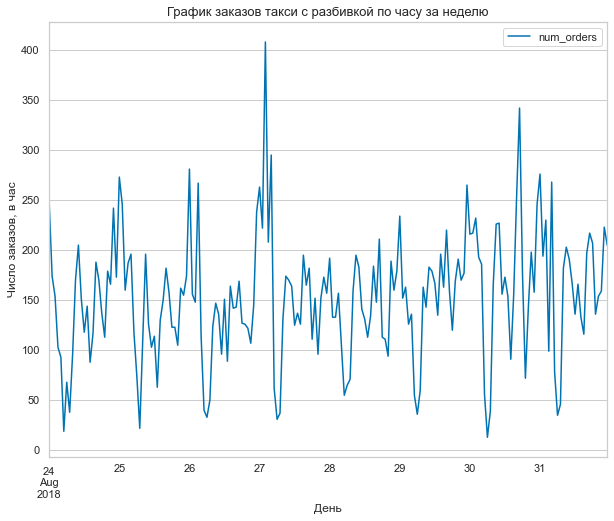

In [12]:
taxi_df_resampled['2018-08-24':'2018-08-31'].plot(figsize=(10, 8))
plt.title('График заказов такси с разбивкой по часу за неделю', fontsize=13)
plt.xlabel('День')
plt.ylabel('Число заказов, в час')
plt.show()

Тут уже можно выделить тренды: видим, что в ночное время (первая половина по каждому дню) число заказов за час падает, чтобы вырасти к вечерному времени (обычный период час-пик). 

Попробуем построить графики трендов, сезонности и остатков по seasonal_decompose(). Для сезонности возьмем срез за ту же последнюю неделю: данных недостаточно, чтобы взять более крупные интервалы и определить на них сезонность.

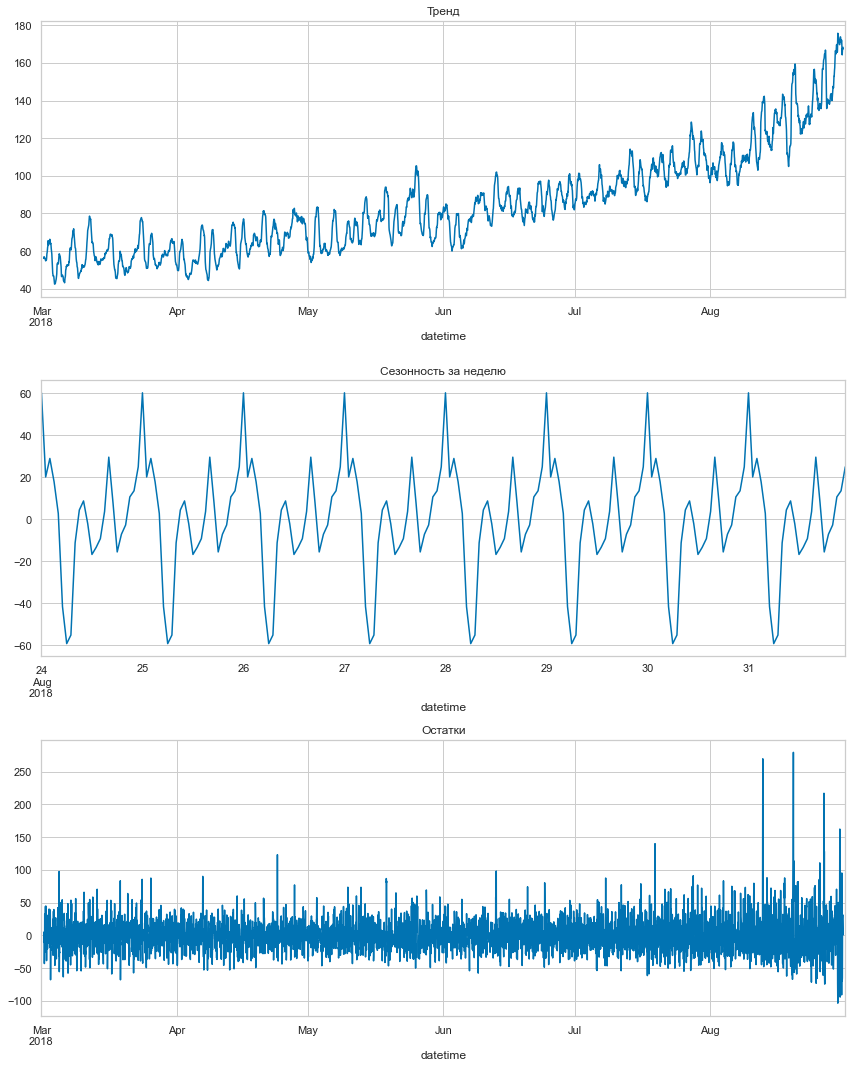

In [13]:
decomposed = seasonal_decompose(taxi_df_resampled)

plt.figure(figsize=(12, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность за неделю')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Какие можно сделать выводы:
    
- График тренда восходящий, число заказов растет от месяца к месяцу. Может, связано с ростом компании, а может, с летним сезоном: тк данные всего за полгода, сложно сказать.
- График сезонности за неделю позволяет потвердить, что пики по числу поездок приходятся на вечерние часы, а спады - на время после полуночи.
- Есть довольно крупные случайные колебания в августе по графику остатков.

Мы видим по скользящему стандартному отклонению и по графику тренда, что наш временной ред нестационарный. Стандартное отклонение, как и средние значения, у него часто меняются. Чтобы сделать ряд стационарным, найдём разности его значений.

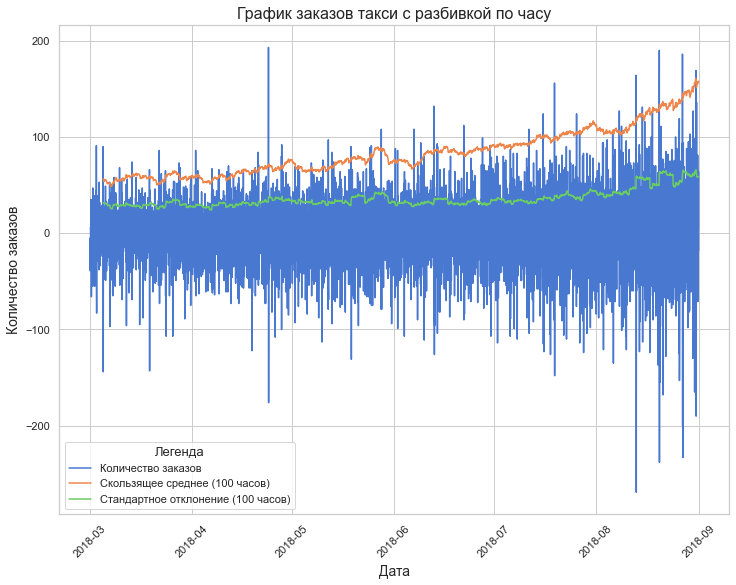

In [14]:
taxi_df_shift = taxi_df_resampled - taxi_df_resampled.shift()
taxi_df_shift['rolling_mean'] = taxi_df_resampled['num_orders'].rolling(100).mean()
taxi_df_shift['std'] = taxi_df_resampled['num_orders'].rolling(100).std()

sns.set(style='whitegrid', palette='muted')
plt.figure(figsize=(12, 9))

sns.lineplot(data=taxi_df_shift, 
             x=taxi_df_shift.index, y='num_orders', label='Количество заказов')
sns.lineplot(data=taxi_df_shift, 
             x=taxi_df_shift.index, y='rolling_mean', label='Скользящее среднее (100 часов)')
sns.lineplot(data=taxi_df_shift, 
             x=taxi_df_shift.index, y='std', label='Стандартное отклонение (100 часов)')

plt.legend(title='Легенда', title_fontsize='13', fontsize='11')
plt.title('График заказов такси с разбивкой по часу', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.xticks(rotation=45)

plt.show()

Проведем еще декомпозицию на сезонность и тренд данных по данным с ресемплированием за сутки из нашего датафрейма. Чтобы посмотреть на недельную сезонность, возьмем период в одну неделю.

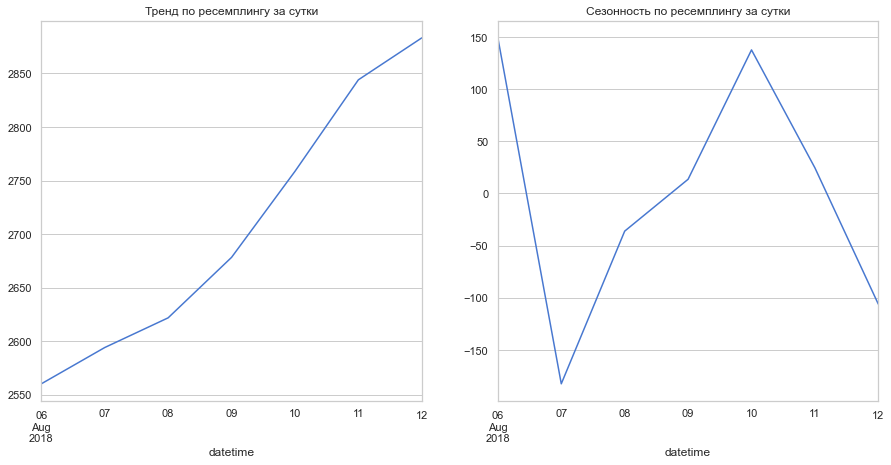

In [15]:
taxi_df_day = taxi_df.resample('1D').sum()

decomposed_1 = seasonal_decompose(taxi_df_day)

plt.figure(figsize=(15, 7))

plt.subplot(121)
decomposed_1.trend['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Тренд по ресемплингу за сутки')

plt.subplot(122)
decomposed_1.seasonal['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Сезонность по ресемплингу за сутки')

plt.show()

Видим, что в данных есть и недельная сезонность: во вторник можно отметить просадку по количеству заказов, а в пятницу - пиковую активность по заказам. Это может быть связано с оживлением спроса к выходным (поездки в места досуга).

## Выводы:

- Дата и время в датафрейме расположены в хронологическом порядке
- В датафрейме указано количество заказов такси за каждые 10 минут. Поменяти интервал на один час и сгруппировали значения с помощью ресемплинга
- Видны довольно большие колебания, сгладили с помощью скользящего среднего, методом перебора нашли наиболее подходящее значение окна в 100.
- График тренда восходящий, число заказов растет от месяца к месяцу. Может, связано с ростом компании, а может, с летним сезоном: тк данные всего за полгода, сложно сказать.
- График сезонности позволяет потвердить, что пики по числу поездок приходятся на вечерние часы, а спады - на время после полуночи.
- Есть и неделюная сезонность: во вторник можно отметить просадку по количеству заказов, а в пятницу - пиковую активность по заказам. 
- Есть довольно крупные случайные колебания в августе по графику остатков.

## Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ числовых данных:

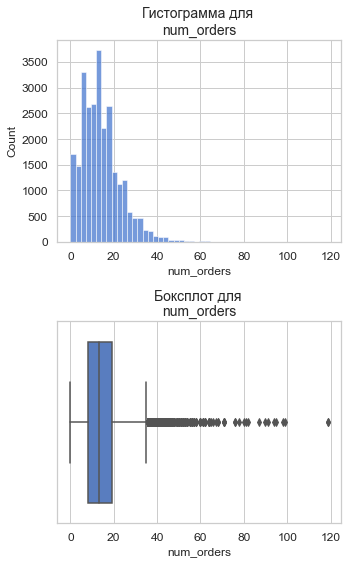

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [16]:
histbox(taxi_df)
taxi_df.describe()

### Выводы по распределению числовых признаков:

- **num_orders**: ненормальное мультимодальное распределение. 
- Среднее  13, медиана 14.07, min 0, max 119. 
- Боксплот показывает, что аномалии начинаются с показатели в 40 заказов, но нам пока это значение не кажется порогом по аномалии. 
- Вполне допустимо, что у сервиса может быть и 40, и 100 заказов такси в пиковые часы.

## Шаг 4. Подготовка данных 

Создадим дополнительные признаки с помщощью функции make_features(). В данном случае нам понадобятся признаки со значением месяца, дня недели и дня месяца, а также создадим значение часа. Максимальный размер отставания установим как 24 часа (столько в сутках), а rolling_mean_size на 48 часов

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [18]:
make_features(taxi_df_resampled, max_lag=168, rolling_mean_size=168) 

taxi_df_resampled.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Шаг 5. Обучение моделей 

Начнем с простой модели линейной регрессии. Перед этим разобьем данные на тренировочную и тестовую выборки: валидационную выборку не создаем, так как далее используем кросс-валидацию. Еще проведем масштабирование числового признака.

Обучим ее на тренировочных данных и оценим ее работу на валидационной выборке по RMSE. Коэффициент детерминации в случае прогнозов по временному ряду использовать не будем.

In [19]:
taxi_df_resampled = taxi_df_resampled.dropna()

train, test = train_test_split(taxi_df_resampled, shuffle=False, test_size=0.1)

train = train.dropna()
test = test.dropna()

X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']

X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

In [20]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
my_cv = TimeSeriesSplit(n_splits=8).split(X_train)
regressor = LinearRegression()

parameters = {
              'fit_intercept': [True, False]
             }

lsearch = GridSearchCV(estimator=regressor,
                       param_grid=parameters,
                       scoring='neg_root_mean_squared_error',
                       cv=my_cv)

lsearch.fit(X_train, y_train)

metric_lr = -lsearch.best_score_
print(f'Качество по кросс-валидации линейной регрессии: {round(metric_lr, 2)}')

Качество по кросс-валидации линейной регрессии: 22.99


В целом модель неплохо справляется, судя по RMSE на валидационной выборке, и проходит под требования к этой метрике. Попробуем найти лучшие параметры для CatBoostRegressor и обучить ее, а затем посчитать RMSE:

In [22]:
my_cv = TimeSeriesSplit(n_splits=8).split(X_train)

regressor = CatBoostRegressor(iterations=200, thread_count=-1, verbose=False)

# Определение сетки гиперпараметров
hyperparams = {
    'learning_rate': [0.1, 0.2, 0.3],
    'depth': [4, 6],
    'random_state': [1515]
}

# Настройка GridSearchCV
gsearch = GridSearchCV(estimator=regressor,
                       param_grid=hyperparams,
                       scoring='neg_root_mean_squared_error',
                       cv=my_cv)

gsearch.fit(X_train, y_train)

metric_cbr = -gsearch.best_score_
print(f'Качество по кросс-валидации CatBoostRegressor: {round(metric_cbr, 2)}')

Качество по кросс-валидации CatBoostRegressor: 22.09


Отлично, CatBoostRegressor показал еще лучшую RMSE на валидационной выборке. А как справится LGBM Regressor?

In [23]:
my_cv = TimeSeriesSplit(n_splits=8).split(X_train)

lregressor = LGBMRegressor()

# Определение сетки гиперпараметров
hyperparams = {
    'num_leaves': [11, 50, 100], 
    'learning_rate': [0.1, 0.3]
}

# Настройка GridSearchCV
gsearch_lbgm = GridSearchCV(estimator=lregressor,
                     param_grid=hyperparams,
                     scoring='neg_root_mean_squared_error',
                     cv=my_cv,
                     return_train_score=False)

# Обучение модели с GridSearchCV
gsearch_lbgm.fit(X_train, y_train)

# Среднее RMSE по кросс-валидации из GridSearchCV
metric_lgbm = -gsearch_lbgm.best_score_
print(f'Качество по кросс-валидации LGBMRegressor: {round(metric_lgbm, 2)}')

Качество по кросс-валидации LGBMRegressor: 22.34


### Выводы:

- Мы разбили данные на тренировочную, валидационную и тестовую выборки с параметрами shuffle=False и размером тестовой выборки в 10% от датафрейма.
- Далее обучили на тренировочных данных три модели: линейную регрессию, CatBoostRegressor и LGBM Regressor. Промежуточную оценку провели на метрике RMSE по валидационной выборке.
- С помощью GridSearchCV нашли лучшие гиперпараметры для LGBM Regressor и CatBoostRegressor.

## Шаг 6. Тестирование и оценка моделей 

Оценим модель на адекватность с использованием предыдущих значений временного ряда для предсказания следующего значения. Если RMSE для моделей будет ниже, чем RMSE для проверки на адекватность, то модель не просто вставляет предыдущие значения временного ряда для предсказаний.

In [24]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
rmse_control = mean_squared_error(y_test, pred_previous, squared=False)

print('RMSE для проверки модели на адекватность:', round(rmse_control, 3))

RMSE для проверки модели на адекватность: 58.82


Соберем табличку с показателями трех моделей и контрольной метрикой для сравнения: 

In [25]:
final = {
    'Модель': ['Линейная регрессия', 'CatBoost Regressor', 
               'LGBM Regressor', 'Контрольная метрика'],
    'RMSE': [metric_lr, metric_cbr, metric_lgbm, rmse_control]
}

final_df = pd.DataFrame(final)
final_df

,Модель,RMSE
0,Линейная регрессия,22.991928
1,CatBoost Regressor,22.086771
2,LGBM Regressor,22.343367
3,Контрольная метрика,58.819725


Мы видим, что все модели показали лучшие метрики RMSE на валидационной метрике, чем контрольный показатель, а значит, можно сказать, что они работают адекватно. В лидерах у нас модель CatBoostRegressor с RMSE 22.08: выберем ее для предсказаний и финальной оценки качества на тестовой выборке. Заодно оценим дополнительно время для предсказаний.

In [26]:
start = time()

preds_fin = gsearch.predict(X_test)

end = time()

fin_time_pred = (end-start)/60

# Рассчет RMSE на тестовой выборке
rmse = mean_squared_error(y_test, preds_fin, squared=False)
print(f'RMSE CatBoost Regressor на тестовой выборке: {rmse:.6f}')
print(f'Время предсказаний на тестовой выборке CatBoost Regressor: {round(fin_time_pred, 5):.5f}')

RMSE CatBoost Regressor на тестовой выборке: 37.631257
Время предсказаний на тестовой выборке CatBoost Regressor: 0.00028


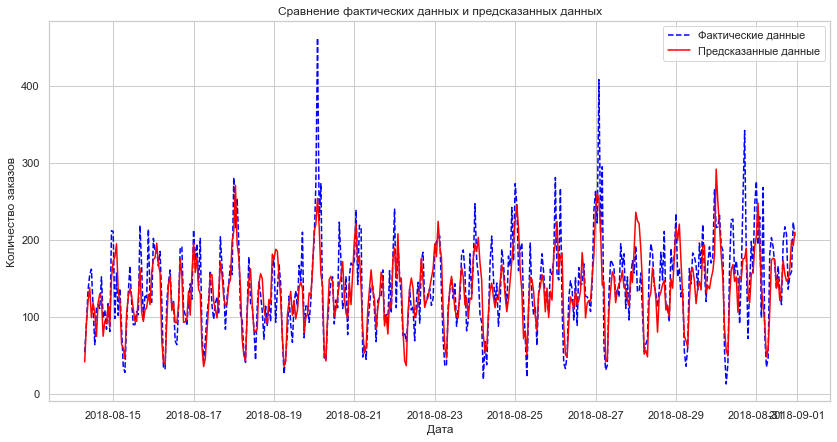

In [27]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test.values, label='Фактические данные', color='blue', linestyle='--')
plt.plot(y_test.index, preds_fin, label='Предсказанные данные', color='red')

plt.title('Сравнение фактических данных и предсказанных данных')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

## Общий вывод:

При выполнении проекта проделана следующая работа:

**На первом этапе произведена загрузка данных и их подготовка для обучения моделей**

- В датафрейме две колонки, названия которых приведены к "змеиному" регистру, и 26496 строк. 
- Пропусков и очевидных дубликатов не видим. 
- Есть данные за полгода: с марта 2018 года по август того же года. 
- Скорее всего, данные структурированы по количеству заказов за каждые 10 минут.

**Далее провели предобработку и визуализировали временной ряд**

- Дата и время в датафрейме расположены в хронологическом порядке
- В датафрейме указано количество заказов такси за каждые 10 минут. Поменяти интервал на один час и сгруппировали значения с помощью ресемплинга
- Видны довольно большие колебания, сгладили с помощью скользящего среднего, методом перебора нашли наиболее подходящее значение окна в 100.
- График тренда восходящий, число заказов растет от месяца к месяцу. Может, связано с ростом компании, а может, с летним сезоном: тк данные всего за полгода, сложно сказать.
- График сезонности за неделю позволяет потвердить, что пики по числу поездок приходятся на вечерние часы, а спады - на время после полуночи.
- Есть довольно крупные случайные колебания в августе по графику остатков.

**Следующим этапом изучили распределение числового признака**

- **num_orders**: ненормальное мультимодальное распределение. 
- Среднее  13, медиана 14.07, min 0, max 119. 
- Боксплот показывает, что аномалии начинаются с показатели в 40 заказов, но нам пока это значение не кажется порогом по аномалии. 
- Вполне допустимо, что у сервиса может быть и 40, и 100 заказов такси в пиковые часы.

**Создали дополнительные признаки с помщощью функции make_features()**
- В данном случае нам понадобились признаки со значением дня недели и часа. 
- Максимальный размер отставания установили как 168 часов (столько в неделе), а rolling_mean_size на такое же значение

**Начали работу с моделями**

- Мы разбили данные на тренировочную и тестовую выборки с параметрами shuffle=False и размером тестовой выборки в 10% от датафрейма.
- Далее обучили на тренировочных данных три модели: линейную регрессию, CatBoostRegressor и LGBM Regressor. Промежуточную оценку провели на метрике RMSE по кросс-валидации
- С помощью GridSearchCV нашли лучшие гиперпараметры 

**Оценили модели на адекватность с использованием предыдущих значений временного ряда для предсказания следующего значения**

- Все модели показали лучшие метрики RMSE на валидационной метрике, чем контрольный показатель, а значит, можно сказать, что они работают адекватно. 
- В лидерах у нас модель CatBoostRegressor с RMSE 22.08
- Провели предсказания на тестовой выборке: RMSE получили в 37.6